In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split
from skimage.transform import resize

In [ ]:
# showing some example images 
image0 = np.load('train/img/train_2.npy')
mask0 = np.load('train/seg/train_2.npy')


image0.shape
plt.imshow(image0)
plt.imshow(mask0, alpha=0.5)
np.where(mask0 == 9)



img_files = [f for f in os.listdir("train/img") if not f.startswith(".")]

n = len(img_files)

train_files, validation_files = train_test_split(img_files, test_size=0.2, random_state=42)


class SegmentationDataset(tf.keras.utils.Sequence):
    def __init__(self, img_folder, seg_folder, file_list, batch_size=32, image_size=(256, 256)):
        self.img_folder = img_folder
        self.seg_folder = seg_folder
        self.batch_size = batch_size
        self.image_size = image_size
        self.img_files = file_list
        self.num_samples = len(self.img_files)
        
    def __len__(self):
        return int(np.ceil(self.num_samples / float(self.batch_size)))
    
    def __getitem__(self, idx):
        batch_img_files = self.img_files[idx * self.batch_size: (idx + 1) * self.batch_size]
        batch_imgs = []
        batch_segs = []
        
        for img_file in batch_img_files:
            img_path = os.path.join(self.img_folder, img_file)
            seg_path = os.path.join(self.seg_folder, img_file)
            
            img = np.load(img_path, allow_pickle=True)
            seg = np.load(seg_path, allow_pickle=True)
            seg = tf.expand_dims(seg, axis=-1)
            
            img = resize(img, self.image_size)
            seg = resize(seg, self.image_size, order=0, mode='reflect', cval=0, clip=True, preserve_range=True, anti_aliasing=False, anti_aliasing_sigma=None)
            
            seg = tf.keras.utils.to_categorical(seg, num_classes=21) if np.max(seg) < 21 else seg
            # seg = np.argmax(seg, axis=-1)                         This line completely removes the predicted class dimension, i commented it out otherwise code doesn't work
            batch_imgs.append(img)
            batch_segs.append(seg)
        
        return np.array(batch_imgs), np.array(batch_segs)
    

img_folder = "train/img"
seg_folder = "train/seg"
batch_size = 32
image_size = (256, 256)

train_dataset = SegmentationDataset(img_folder, seg_folder, batch_size=batch_size, image_size=image_size, file_list=train_files)
val_dataset = SegmentationDataset(img_folder, seg_folder, batch_size=batch_size, image_size=image_size, file_list=validation_files)

In [ ]:
import os 
class TestDataset(tf.keras.utils.Sequence):
    def __init__(self, img_folder, file_list, batch_size=32, image_size=(256, 256)):
        self.img_folder = img_folder
        self.batch_size = batch_size
        self.image_size = image_size
        self.img_files = file_list
        self.num_samples = len(self.img_files)
        
    def __len__(self):
        return int(np.ceil(self.num_samples / float(self.batch_size)))
    
    def __getitem__(self, idx):
        batch_img_files = self.img_files[idx * self.batch_size: (idx + 1) * self.batch_size]
        batch_imgs = []
        
        for img_file in batch_img_files:
            img_path = os.path.join(self.img_folder, img_file)
            
            img = np.load(img_path, allow_pickle=True)
            img = resize(img, self.image_size)
            
            batch_imgs.append(img)
        
        return np.array(batch_imgs)

# Assuming you have a list of test files and the test images are in the 'test/img' folder
test_img_folder = "test/img"
test_files = [f for f in os.listdir(test_img_folder) if not f.startswith(".")]


In [ ]:
test_dataset = TestDataset(test_img_folder, batch_size=batch_size, image_size=image_size, file_list=test_files)
predictions = Segnet.predict(test_dataset)

/Users/thibaultheintz/miniconda3/envs/CV/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


750/750 ━━━━━━━━━━━━━━━━━━━━ 268s 357ms/step


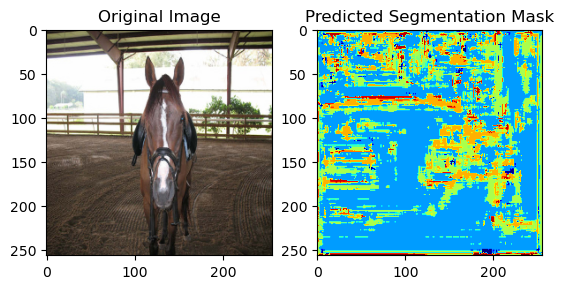

In [ ]:
import matplotlib.pyplot as plt

# Get a batch of data from the test dataset
test_images = test_dataset[4]

# Get the corresponding predictions
test_predictions = predictions[:len(test_images)]

# For each image in the batch
for i in range(len(test_images)):
    # Get the image and its corresponding prediction
    img = test_images[i]
    pred = test_predictions[i]
    
    # The prediction is a one-hot encoded matrix, we need to convert it to a single channel matrix
    pred = np.argmax(pred, axis=-1)
    
    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2)
    
    # Plot the original image in the first subplot
    axes[0].imshow(img)
    axes[0].set_title('Original Image')
    
    # Plot the predicted segmentation mask in the second subplot
    axes[1].imshow(pred, cmap='jet')
    axes[1].set_title('Predicted Segmentation Mask')
    
    # Show the figure
    plt.show()
